# CA county-level COVID-19 policy extraction from official twitter accounts

This notebook hopes to county official/county public health/county office of emergency service tweets in California to get their COVID-19 policy. Nearly all COVID-19 policy trackers are using crowdsourcing. This work can potentially reduce some of their worklaod.

In [299]:
from tweepy import OAuthHandler
from tweepy import API
from tweepy import Cursor
import tweepy
from datetime import datetime, date, time, timedelta
from collections import Counter
import sys
import pandas as pd
import datetime
import time
from datetime import datetime
import re
import nltk.data
import plotly.graph_objects as go
import plotly.figure_factory as ff
from openpyxl import Workbook


# Data scraping
Input your twitter developer account info to authorize. You can get a free twitter developer account and your keys at https://developer.twitter.com/en/apply-for-access 

In [2]:
consumer_key = "Consumer key here"
consumer_secret = "Consumer secret here"
access_token = "Access token here"
access_token_secret = "Access token secret here"

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
auth_api = API(auth)

Below is a helper function for finding finding twitter accounts using various combinations of county, state name and department name. A notice to watch out for counties with same name in other states or have same abbreviation.  

In [3]:
def generate_name(county,state,countylongname):
    names = []
    names.append(countylongname.replace(" ",""))
    names.append(county.replace(" ", ""))
    county_short = county.replace(" County",'')    
    names.append(county_short.replace(' ','')+state)
    names.append('Countyof'+county_short.replace(" ",""))
    names.append('Countyof'+county[0] + county[county.find(' ') + 1])
    names.append('County'+county_short.replace(' ',''))
    names.append(county_short[:3]+'County'+countylongname[-2:])
    names.append(county[0] + county[county.find(' ') + 1]+'county')
    names.append(county_short)
    county_names = names.copy()
    names.extend([x+'Health' for x in county_names])
    names.extend([x+'HlthDept' for x in county_names])
    names.extend([x+'dph' for x in county_names])
    names.extend([x+'oes' for x in county_names])
    names.extend([x+'gov' for x in county_names])
    names.extend([x+'cagov' for x in county_names])
    names.extend([x+'emergency' for x in county_names])
    return  names
def find_accounts(df):
    ans = []
    for i in range(df.shape[0]):
        row = df.iloc[i]
        names = generate_name(row['county_name'],row['state_name'],row['long_name'])
        curr = []
        j = 0
        while j < len(names):
            x = names[j]
            try:
                u = auth_api.get_user(x)
                curr.append(u)
                j += 1
            except tweepy.TweepError as e:
                if 'User not found.' in str(e) or 'User has been suspended.' in str(e):
                    j += 1
                    continue
                print(e,i,j)
                time.sleep(900)
        ans.append(curr)
    df['account'] = ans
    return df


I haved found 51(out of 58 counties in CA) and saved their account names at 'names_ca.csv'. Let's directly import that. 
Since twitter has twitter API limitation with tweepy, whenever it reaches the limit, the program will pause, print the error message and wait for 15mins. This process usually takes about an hour. 


You can also skip this step to load from "df_20200827.pkl" directly, which will contain tagged tweets until 2020-08-27 morning. 

In [26]:
def get_date(time):
    return datetime. strptime(time, '%a %b %d %H:%M:%S %z %Y').date()
def get_tweets(user):
    new_tweets = auth_api.user_timeline(id = user.id,count = 200, wait_on_rate_limit = True,wait_on_rate_limit_notify=True, tweet_mode='extended')
    alltweets = []
    while len(new_tweets) > 0:
        oldest = new_tweets[-1].id - 1
        alltweets.extend(new_tweets)
        new_tweets = auth_api.user_timeline(id = user.id,count = 200, max_id = oldest,wait_on_rate_limit = True,wait_on_rate_limit_notify=True, tweet_mode='extended')
    return alltweets
def get_dated_text(account):
    def get_full_text(tweet):
        if 'retweeted_status' in tweet._json:
            return(tweet._json['retweeted_status']['full_text'])
        else:
            if 'full_text' in tweet._json:
                 return(tweet._json['full_text'])
    if not(account):
        return []
    ans = []
    texts = set()
    alltweets = get_tweets(account)
    for tweet in alltweets:
        date = get_date(tweet._json['created_at'])
        text = get_full_text(tweet)
        if text in texts:
            continue
        ans.append((date,text))
        texts.add(text)
    return ans
def get_dated_tweets(df):
    i = 0
    ans = []
    while i < df.shape[0]:
        try:
            account = df.loc[i,'account']
            ans.append(get_dated_text(account))
            i += 1
        except tweepy.TweepError as e:
            print(str(e) + str(i))
            if str(e) == 'Not authorized.':
                ans.append([])
                i += 1
                continue
            time.sleep(900)  
    df['dated_tweets'] = ans
    return df
def find_accounts(df):
    ans = []
    i = 0
    while i < df.shape[0]:
        name = df.loc[i,'names']
        if not name:
            i += 1
            continue
        try:
            u = auth_api.get_user(name)
            df.loc[i,'account'] = u
            i += 1
        except tweepy.TweepError as e:
            if 'User not found.' in str(e) or 'User has been suspended.' in str(e):
                i += 1
                continue
            print(i,e)
            time.sleep(900)
    return df

df2 = pd.read_excel('names_ca.xlsx')
df2 = df2.fillna("")
df2 = find_accounts(df2[['county','names']])
df2 = df2.fillna("")
df2 = get_dated_tweets(df2)

36 Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/users/show.json?id=SanDiegoCounty (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f80aab06290>: Failed to establish a new connection: [Errno 110] Connection timed out'))
Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/user_timeline.json?id=80374052&count=200&max_id=70335758921244671&tweet_mode=extended (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7f80aca5d710>: Failed to establish a new connection: [Errno 110] Connection timed out'))6
Not authorized.15
Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/user_timeline.json?id=193771633&count=200&max_id=1283922621566873599&tweet_mode=extended (Caused by NewConnectionError('<urllib3.connection.Ver

Uncomment to use saved df2. You can also add tweets(starting 2020/08/27) directly onto the saved dataframe to save running time. 

In [310]:
##Uncomment to use saved df2.
#df2 = pd.read_pickle('df2_20200827.pkl')

# Data analysis
I'm using some 60+ COVID-19 related keywords from https://ieee-dataport.org/open-access/coronavirus-covid-19-geo-tagged-tweets-dataset for the filtering starting 2020/01/20. I also added keywords reopen, close becase some of the tweets will mention "xxx business will reopen" etc. This will also include some open and close not due to COVID-19, such as ones due to the wildfire. Depending on your purpose, they can be filtered out later.

In [110]:
def add_covid_text(df): 
    start_date = datetime(2020,1,20).date()
    def filter_covid(text):
        dic = {"corona", "#corona", "coronavirus", "#coronavirus", "covid", "#covid", "covid19", "#covid19", "covid-19", "#covid-19", "sarscov2", "#sarscov2", "sars cov2", "sars cov 2", "covid_19", "#covid_19", "#ncov", "ncov", "#ncov2019", "ncov2019", "2019-ncov", "#2019-ncov", "pandemic", "#pandemic" "#2019ncov", "2019ncov", "quarantine", "#quarantine", "flatten the curve", "flattening the curve", "#flatteningthecurve", "#flattenthecurve", "hand sanitizer", "#handsanitizer", "#lockdown", "lockdown", "social distancing", "#socialdistancing", "work from home", "#workfromhome", "working from home", "#workingfromhome", "#ppe", "#n95", "#covidiots", "covidiots", "herd immunity", "#herdimmunity", "pneumonia", "#pneumonia", "chinese virus", "#chinesevirus", "wuhan virus", "#wuhanvirus", "kung flu", "#kungflu", "wearamask", "#wearamask", "wear a mask", "vaccine", "vaccines", "#vaccine", "corona vaccine", "corona vaccines", "#coronavaccine", "#coronavaccines","reopen","closed"}
        ans = []
        for t in text:
            for key in dic:
                if t[0] < start_date:
                    continue
                if t[1].lower().find(key) != -1:
                    ans.append(t)
                    break
        return ans
    ans = []
    for i in range(df.shape[0]):
        ans.append(filter_covid(df.loc[i,'dated_tweets']))
        df.loc[i,'covid_length'] = len(ans[-1])
    df['covid_text'] = ans
add_covid_text(df2)

Add FIPS to the dataframe and plot the distribution of covid related tweets. There are 47 counties with COVID19 updates.

In [313]:
df = pd.read_csv("county_fips.csv")
df_ca = df[df.state_abbr == 'CA'][['county_name','fips']]
df2 =df2.merge(df_ca,left_on='county',right_on = 'county_name')
for i in range(df2.shape[0]):
    s = str(df2.loc[i,'fips'])
    while len(s) < 5:
        s = '0' + s
    df2.loc[i,'fips'] = s
    
def plot_county_ca(df_ca,label):
    df_ca = df_ca[df_ca[label]>0]
    values = df_ca[label].tolist()
    fips = df_ca['fips'].tolist()

    colorscale = [ '#F5C8BB', '#B96D67', '#A83C3B',
       '#8B2222', '#5B0D0D', '#5A2318']
    
    binning = [2**(np.log2(max(values))/4 * (i + 1)) for i in range(4)]
    
    fig = ff.create_choropleth(
        fips=fips, values=values, scope=['CA'],
        binning_endpoints=binning, 
        colorscale=colorscale,
        show_hover=True,
        county_outline={'color': 'rgb(0,0,0)', 'width': 0.5}, round_legend_values=True,
        #legend_title='Population by County', title='California and Nearby States'
        title = 'Number of COVID19 related tweets in county accounts'
    )
    fig.layout.template = None
    fig.show()
plot_county_ca(df2,'covid_length')
print('Counties with 0 COVID-19 related tweets: ')
print(df2[df2['covid_length'] == 0]['county'].values)

Counties with 0 COVID-19 related tweets: 
['Del Norte County' 'Inyo County' 'Kings County' 'Lake County'
 'Lassen County' 'Mariposa County' 'Modoc County' 'Plumas County'
 'Sierra County' 'Tehama County' 'Trinity County']


### Filter and tag tweets with policy info
There are largely four types of COVID-19 related tweets.
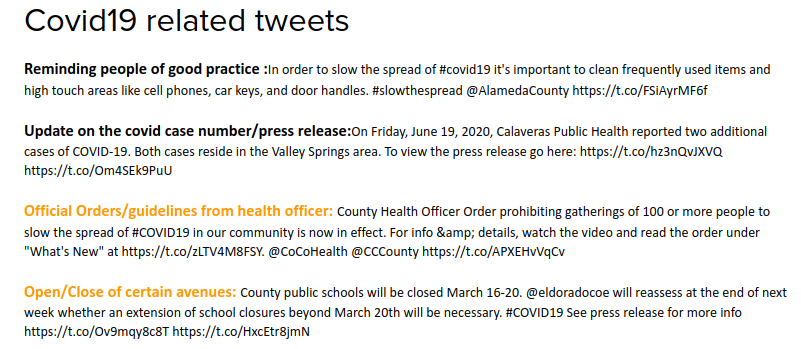
The last two are what we care about. For the third type of tweets, they usually include key words such as orders/guidelines and are easy to distinguish. I tag them in the following scheme by detecting these keywords:


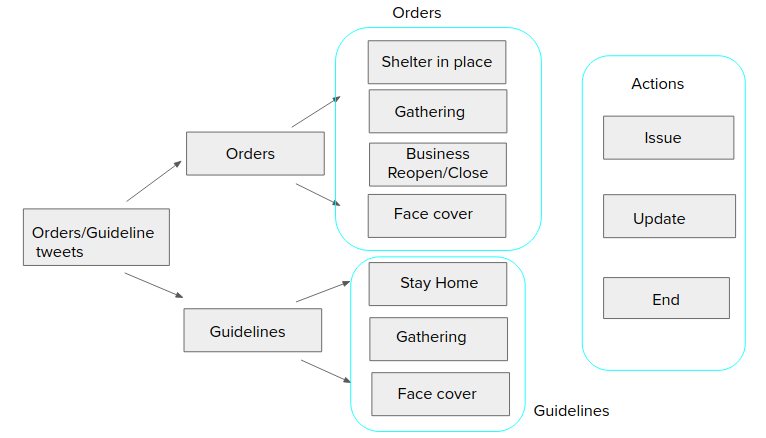

For the fourth type of tweets, I'm hand encoding some lists of business/avenus, keywords in CA reopen('stage 2'), action ('paused') and detect them together with keywords "reopen"


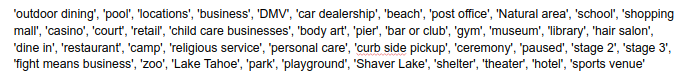

In [325]:
def find_all_occurs(key,text):
    if isinstance(key,list):
        return sum([find_all_occurs(x, text) for x in key])
    return len([m.start() for m in re.finditer(key, text)])
def include_order(t,dic):
    for key in dic.keys():
        if not(dic[key]):
            if t.lower().find(key) != -1:
                return True
        else:
            if find_all_occurs(key,t.lower()) != find_all_occurs(dic[key],t.lower()):
                return True
    return False
def get_orders(text):
    def find_order(sentence, label):
        ans = []
        actions = {'issue':['issue','issuing'],'update':['update','revised','modification','modify','extension','revision','extend','new'],'end':['rescind','expire','cancel']}
        if label == 'order':
            orders = {'shelter in place':['shelter-in-place','shelter in place','shelter at home','shelter-at-home','stay-at-home','stay at home','stay well at home'],
                         'face cover':['mask','face cover','facial covering'],'curfew':['curfew'],'gathering':['gathering','social bubble']}
        if label == 'guideline':
            orders = {'stay at home':['shelter at home','shelter-at-home','stay-at-home','stay at home','stay well at home','stay well to home'],
                         'face cover':['mask','face cover','facial covering'],'curfew':['curfew'],'gathering':['gathering','social bubble']}
        if label == 'open/close':
            actions = {'outdoor dining':['outdoor dining'],'pool':['pool'],'locations':['locations'],'business':['business','industries'],
                        'DMV':['dmv'],'car dealership':['car dealership'],'beach':['beach'],'post office':['post office'],'Natural area':['natural area','trail'],
                         'school':['university','campus','school'],'shopping mall':['shopping mall'],'casino':['casno'],
                         'court':['court'],'retail':['retail'],'child care businesses':['child care business'],
                         'body art':['body art'],'pier':['pier'],'bar or club':['bar','club'],'gym':['gym','fitness'],
                         'museum':['museum','gallery','galleries'],'library':['library','libraries'],'hair salon/nail salon':['hair salon','barbershop','hair or nail salon'],
                         'dine in':['dine in','dine-in','in-person dining','in person dining','indoor dining'],
                         'restaurant':['restaurant'],'camp':['camp'],'religious service':['church','worship','religious service'],
                         'personal care':['personal care','spa','nail salon','body art'],'curb side pickup':['curb side pickup','curbside pickup'],
                         'ceremony':['ceremony','ceremonies'],'paused':['pause','heed','postpone'],'stage 2':['stage 2','stage2','Phase II','phase 2'],
                         'stage 3':['stage 3','stage3','phase 3','Phase III'],'fight means business':['fight means business'],'zoo':['zoo','aquarium'],
                         'Lake Tahoe':['lake tahoe'],'park':['park'],'playground':['playground'],'Shaver Lake':['shaver lake'],
                         'shelter':['shelter'],'theater':['theater','theatre','cinema','movie','film'],
                         'hotel':['hotel', 'lodging','short-term rental'],'sports venue':['sports venues','professional sports']
                     
                     }
            orders = {'open':['reopen','re-open','allow'],'close':['close']}
        sentence = sentence.lower().replace('news','')
        for order in orders.keys():
            for order_w in orders[order]:
                d1 = sentence.find(order_w)
                if d1 == -1:
                    continue
                distance = float('inf')
                curr = ()
                for action in actions.keys():
                    for action_w in actions[action]:
                        d2 = sentence.find(action_w)
                        if d2 != -1:
                            if abs(d1 - d2) < distance:
                                distance = abs(d1 - d2)
                                curr = (order, action)
                if curr:
                    ans.append(curr)
        return ans                 
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    ans = []
    for t in text:
        curr = []
        sentence = t[1].strip()
        if (include_order(sentence,{'order':'in order to','policy':""})):
            orders = find_order(sentence,'order')
            for order in orders:
                curr.append((t[0],'order')+order+(sentence,))
        if (include_order(sentence,{'guideline':'','urge':''})):
            orders = find_order(sentence,'order')
            for order in orders:
                curr.append((t[0],'guideline') + order+(sentence,))
        if (include_order(sentence,{'reopen':'','re-open':'','allow':"",'close':['close contact','close off','close to']})):
            orders = find_order(sentence,'open/close')
            for order in orders:
                curr.append((t[0],'open/close') + order+(sentence,))
        ans.extend(curr)
    return ans 
ans = []
for i in range(df2.shape[0]):
    ans.append(get_orders(df2.loc[i,'covid_text']))
df2['orders'] = ans

### Some thoughts
The current tagging method will include some of the tweets in first type. Further ways of improving may include: 
1. training a simple classifier with some hand labeled data.
2. Use some NLP tools for further analysis. (I tried simple nltk entity extraction to extract business but the businesses are too abstract to extract; I also tried POS tagging in nltk but the results aren't very liable. So I didn't include them here)

## Plots
We can also plot the orders with confirmed/deaths cases. I'm using the deaths and confirmed data from USAFacts. These data are upto the previous day. Since we might have some tweets today, to avoid key error. I'm adding another column to the cases and deaths dataframe with the same counts as the previous day.

In [329]:
cases = pd.read_csv('covid_confirmed_usafacts.csv')
deaths = pd.read_csv('covid_deaths_usafacts.csv')
def get_dates(time):
    return datetime. strptime(time, "%m/%d/%y")
day = (get_dates(cases.columns[-1]) + timedelta(days=1)).strftime("%-m/%-d/%y")
cases[day] = cases[cases.columns[-1]]
deaths[day] = deaths[deaths.columns[-1]]

In [330]:
def plot_county(county, orders, name):
    data = df2[df2.county == county].orders.values[0]
    if name == 'cases':
        count = cases
    else:
        count = deaths
    df_county = pd.DataFrame()
    keys = ['date','category','order','action','text']
    for i in range(len(keys)):
        if i == 0:
            df_county[keys[i]] = [x[i].strftime("%-m/%-d/%y") for x in data]
        else:
            df_county[keys[i]] = [x[i] for x in data]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=count.columns[4:].to_list(), y=count[count['County Name'] == county].values[0][4:],
                           mode='markers',
                            name=name))
    for order in orders:
        tmp = df_county[df_county.order == order]
        fig.add_trace(go.Scatter(x = tmp['date'].values, y = [count[count['County Name'] == county][xx].values[0] for xx in tmp['date']],
                                hovertext=[x[:100] +'<br>' + x[100:200] + '<br>' + x[200:] for x in tmp['text'].values],
                                mode = 'markers',
                                marker=dict(
                                    size=20),
                                name = order))

    fig.update_layout(
    title={
        'text': county},
    xaxis_title="Date",
    yaxis_title=name,)
    fig.show()

Plot Santa Clara county below. Change orders array to plot policis you want to see.

In [331]:
orders = ['shelter in place', 'open', 'close', 'gathering', 'face cover']
plot_county('Santa Clara County', orders, 'cases')
plot_county('Santa Clara County', orders, 'deaths')


Hover over the dots to see the corresponding tweets. There are still some problems with the open/close because of our filterings. Refer to **some thoughts** section above for some possible improvement ideas! 

## Export the tagged results to excel files
Also export df2 to pickle

In [332]:
wb1 = Workbook()
for i in range(df2.shape[0]):
    ws = wb1.create_sheet(df2.loc[i,'county'])
    lines = df2.loc[i,'covid_text']
    for j in range(len(lines)):
        ws.cell(row=j + 1, column=1).value = lines[j][0].strftime("%m/%d/%y")
        ws.cell(row=j + 1, column=2).value = lines[j][1]
wb1.save('covid_related_tweets.xlsx')

wb1 = Workbook()
for i in range(df2.shape[0]):
    ws = wb1.create_sheet(df2.loc[i,'county'])
    lines = df2.loc[i,'orders']
    for j in range(len(lines)):
        for k in range(5):
            if k == 0:
                ws.cell(row=j + 1, column=k + 1).value = lines[j][k].strftime("%m/%d/%y")
            else:
                ws.cell(row=j + 1, column=k + 1).value = lines[j][k]

wb1.save('orders.xlsx')

df2.to_pickle('df2_20200827.pkl')

## Conclusion
We are able to extract county-level COVID-19 policy in CA related tweets and tagging them accordingly. They still require some human post processing for 100% accuracies. I'm hoping this will help people interested in curating such databases or studying influence of policies half-automize their work. 

Some improvements can be done:
 1. Better ways to classify and tagg (refer to **some thoughts** section).
 2. Some of the tweets have a very brief header (such as new shelter in place update)with an external link to the full guide. Currently we just tag them as "order, Shelter in place, update". Might be helpful if scrape the external link for more detailed information.
 3. The pipeline can be scaled into other states with verified twitter accounts and tagging schemes
 
 